In [1]:
%%HTML
<style type='text/css'>
    *{
        # background-color:#E3EDCD;
        # background-color:black;
        # color:white;
        
    }
    h1{
        color:#1976d2;
    }
    h2{
        color:#f57c00;
    }
    h3{
        color:#ba37ff;
    }
    
    h4{
        color:green;
    }
    table{
        border:1px solid black !important;
        border-collapse:collapse !important;
    }
     th{
        background-color:blueviolet !important;
        text-align:center !important;
        color:white;
    }
     th,td{
        border:0.1px solid black !important;
        text-align:center !important;
        transition:0.2s all liner !important;
        
    }
     td:hover{
        transform:scale(1.1);
        background-color:orange;
        color:blueviolet;
    }
    .raw{
        white-space:pre;
    }
    .atcenter{
        text-align:center !important;
    }
    .imp{
        color:red;
        font-weight:bolder;
    }
     table.tts tr:first-child td:nth-child(2){
        background-color:red !important;
    }
     table.tts tr:nth-child(2) td:last-child{
        background-color:red !important;
    }
</style>

## 5.7 专题：支持向量机 

支持向量机（support vector machine，SVM）是非常强大、灵活的有监
督学习算法，既可用于分类，也可用于回归。在本节中，我们将介绍支
持向量机的原理，并用它解决分类问题。首先还是导入需要用的程序
库：


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# 用Seaborn画图
import seaborn as sns; sns.set()

### 5.7.1 支持向量机的由来

在前面介绍贝叶斯分类器（详情请参见 5.5 节）时，我们首先对每个类
进行了随机分布的假设，然后用生成的模型估计新数据点的标签。那是
生成分类方法，这里将介绍判别分类方法：不再为每类数据建模，而是
用一条分割线（二维空间中的直线或曲线）或者流形体（多维空间中的
曲线、曲面等概念的推广）将各种类型分割开。      
下面用一个简单的分类示例来演示，其中两种类型的数据可以被清晰地
分割开（如图 5-53 所示）：


下面用一个简单的分类示例来演示，其中两种类型的数据可以被清晰地
分割开（如图 5-53 所示）：

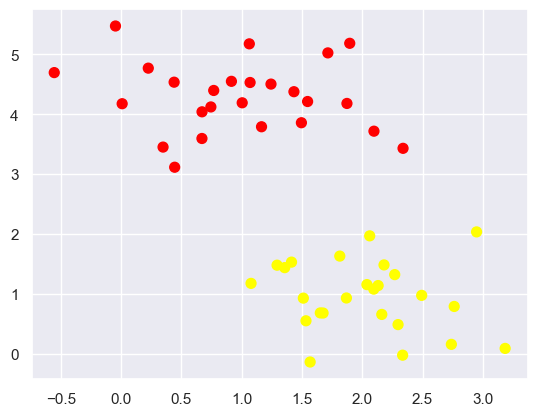

In [10]:
# from sklearn.datasets.samples_generator import make_blobs
# python数据科学手册对于一些写法细节相当随意故而有许多错误的代码
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                    random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

<p class='atcenter'>图 5-53：简易分类数据</p>

这个线性判别分类器尝试画一条将数据分成两部分的直线，这样就构成
了一个分类模型。对于上图的二维数据来说，这个任务其实可以手动完
成。但是我们马上发现一个问题：在这两种类型之间，有不止一条直线
可以将它们完美分割。               
可以把它们画出来看看（如图 5-54 所示）

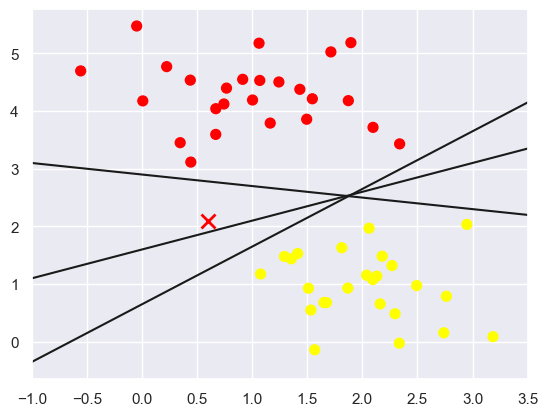

In [11]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
        plt.plot(xfit, m * xfit + b, '-k')
        plt.xlim(-1, 3.5);

<p class='atcenter'>图 5-54：三条完美的线性判别分类器</p>

虽然这三个不同的分割器都能完美地判别这些样本，但是选择不同的分
割线，可能会让新的数据点（例如图 5-54 中的“X”点）分配到不同的标
签。显然，“画一条分割不同类型的直线”还不够，我们需要进一步思考。


### 5.7.2 支持向量机：边界最大化

支持向量机提供了改进这个问题的方法，它直观的解释是：不再画一条
细线来区分类型，而是画一条到最近点边界、有宽度的线条。具体形式
如下面的示例所示（如图 5-55 所示）：

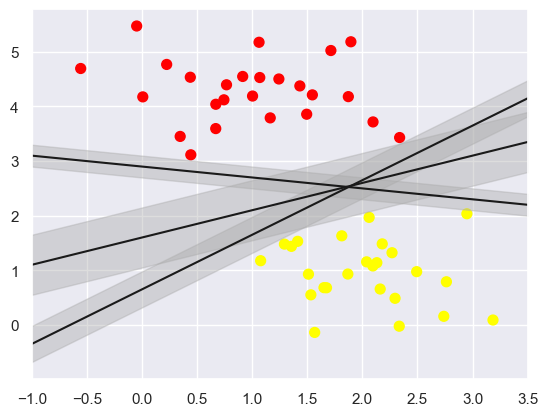

In [12]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA',
    alpha=0.4)
plt.xlim(-1, 3.5);

<p class='atcenter'>图 5-55：带“边界”的判别分类器</p>

#### 01. 拟合支持向量机 

来看看这个数据的真实拟合结果：用 Scikit-Learn 的支持向量机分
类器在数据上训练一个 SVM 模型。这里用一个线性核函数，并将
参数 C 设置为一个很大的数（后面会介绍这些设置的意义）：

In [13]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)


SVC(C=10000000000.0, kernel='linear')

为了实现更好的可视化分类效果，创建一个辅助函数画出 SVM 的
决策边界（如图 5-56 所示）：

In [32]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """画二维SVC的决策函数"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # 创建评估模型的网格
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    # 画决策边界和边界
    ax.contour(X, Y, P, colors='k',
                levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
# 画支持向量
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, facecolors='none',linewidth=1,edgecolors='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [30]:
plt.scatter?

Signature:
plt.scatter(
    x: 'float | ArrayLike',
    y: 'float | ArrayLike',
    s: 'float | ArrayLike | None' = None,
    c: 'ArrayLike | Sequence[ColorType] | ColorType | None' = None,
    marker: 'MarkerType | None' = None,
    cmap: 'str | Colormap | None' = None,
    norm: 'str | Normalize | None' = None,
    vmin: 'float | None' = None,
    vmax: 'float | None' = None,
    alpha: 'float | None' = None,
    linewidths: 'float | Sequence[float] | None' = None,
    *,
    edgecolors: "Literal['face', 'none'] | ColorType | Sequence[ColorType] | None" = None,
    plotnonfinite: 'bool' = False,
    data=None,
    **kwargs,
) -> 'PathCollection'
Docstring:
A scatter plot of *y* vs. *x* with varying marker size and/or color.

Parameters
----------
x, y : float or array-like, shape (n, )
    The data positions.

s : float or array-like, shape (n, ), optional
    The marker size in points**2 (typographic points are 1/72 in.).
    Default is ``rcParams['lines.markersize'] ** 2``.

    Th

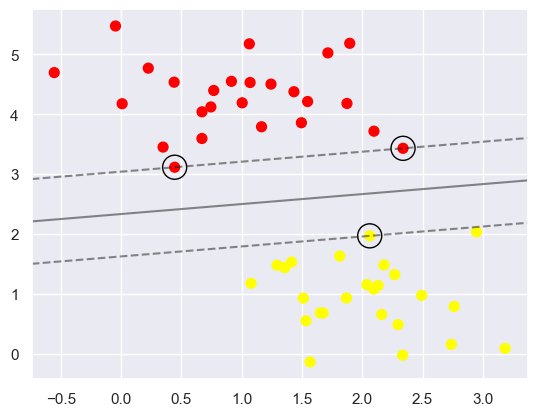

In [33]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

<p class='atcenter'>图 5-56：带边界线（虚线）和支持向量（圆圈）的支持向量机分
类器拟合数据结果</p>

这就是两类数据间隔最大的分割线。你会发现有一些点正好就在边
界线上，在图 5-56 中用黑圆圈表示。这些点是拟合的关键支持
点，被称为支持向量，支持向量机算法也因此得名。在 ScikitLearn 里面，支持向量的坐标存放在分类器的 support_vectors_
属性中：

In [34]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

分类器能够成功拟合的关键因素，就是这些支持向量的位置——任
何在正确分类一侧远离边界线的点都不会影响拟合结果！从技术角
度解释的话，是因为这些点不会对拟合模型的损失函数产生任何影
响，所以只要它们没有跨越边界线，它们的位置和数量就都无关紧
要。


例如，可以分别画出数据集前 60 个点和前 120 个点的拟合结果，并进行对比（如图 5-57 所示）：

In [ ]:
def plot_svm(N=10, ax=None):

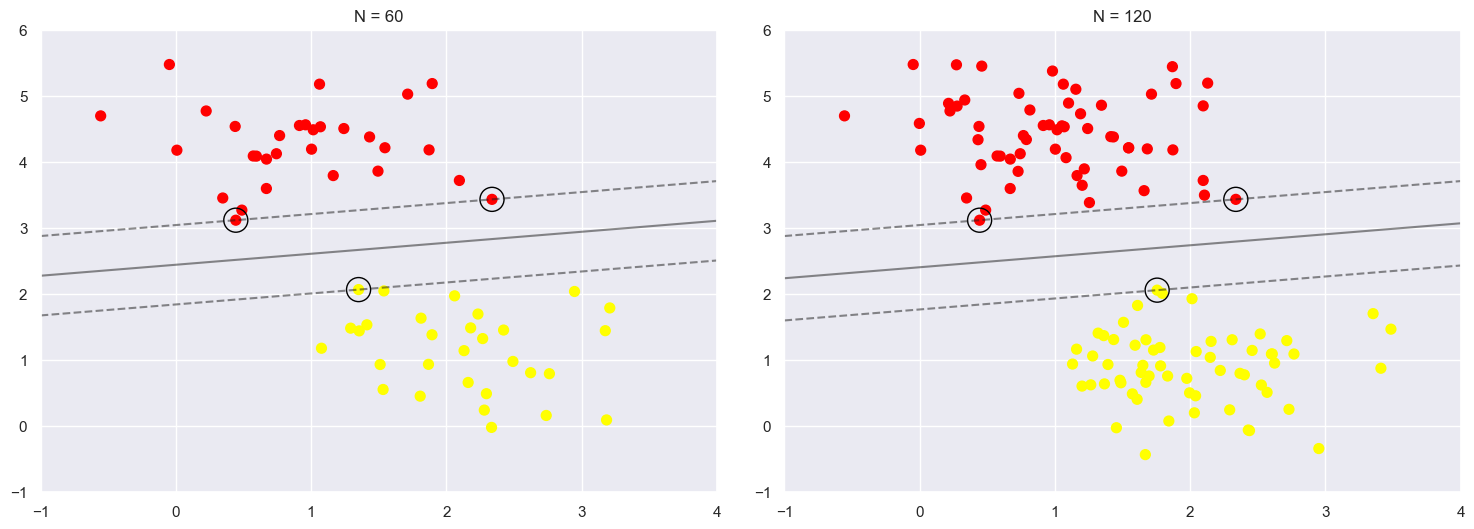

In [35]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=N, centers=2,\
                random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, \
                    wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

<p class='atcenter'>图 5-57：新训练数据点对 SVM 模型的影响</p>

我们在左图中看到的是前 60 个训练样本的模型和支持向量。在右
图中，虽然我们画了前 120 个训练样本的支持向量，但是模型并没
有改变：左图中的 3 个支持向量仍然适用于右图。这种对远离边界
的数据点不敏感的特点正是 SVM 模型的优点之一。

如果你正在运行 Notebook，可以用 IPython 的交互组件动态观察
SVM 模型的这个特点（如图 5-58 所示）：

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

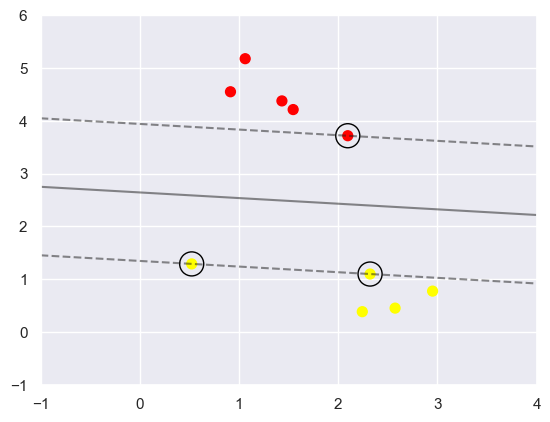

In [36]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));